In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
import shap  # Import SHAP
import lime  # Import LIME
import lime.lime_tabular

In [2]:
df=pd.read_csv("./Dataset/bikesCleaned.csv")
df.head()

,Unnamed: 0,name,brand,price,max power,max torque,cooling system,transmission,transmission type,displacement,...,front tyre pressure (rider & pillion),rear tyre pressure (rider & pillion),kerb weight,overall length,overall width,wheelbase,ground clearance,seat height,overall height,chassis type
0,0,Royal Enfield Hunter 350,Royal Enfield,149900,20.2,27.0,air/oil cooled,5 speed manual,chain drive,349.0,...,29.0,33.0,177.0,2055,800.0,1370,150.0,790,1055,double-downtube frame
1,1,Royal Enfield Classic 350,Royal Enfield,190229,20.2,27.0,air/oil cooled,5 speed manual,chain drive,349.0,...,22.0,32.0,195.0,2145,785.0,1390,170.0,805,1090,twin downtube spine frame
2,2,Royal Enfield Bullet 350,Royal Enfield,157391,19.1,28.0,air cooled,5 speed manual,chain drive,346.0,...,22.0,32.0,186.0,2170,810.0,1395,135.0,800,1120,"single downtube,using engine as stressed member"
3,3,Royal Enfield Continental GT 650,Royal Enfield,304945,47.0,52.0,air/oil cooled,6 speed manual,chain drive,648.0,...,32.0,39.0,198.0,2122,744.0,1398,174.0,793,1024,"steel tubular, double cradle frame"
4,4,Royal Enfield Meteor 350,Royal Enfield,200924,20.2,27.0,air/oil cooled,5 speed manual,chain drive,349.0,...,32.0,36.0,191.0,2140,845.0,1400,170.0,765,1140,twin downtube spine frame


## Data preprocessing

#### Using pandas_profiling EDA task

In [ ]:
# from pandas_profiling import ProfileReport
# prof = ProfileReport(df)
# prof.to_file(output_file='output.html')

In [3]:
df.shape

(173, 45)

In [4]:
df.count()

Unnamed: 0                               173
name                                     173
brand                                    173
price                                    173
max power                                173
max torque                               173
cooling system                           173
transmission                             173
transmission type                        173
displacement                             173
cylinders                                173
bore                                     173
stroke                                   173
valves per cylinder                      173
spark plugs                              173
gear shifting pattern                    173
clutch                                   173
fuel tank capacity                       173
mileage - arai                            38
mileage - owner reported                 110
top speed                                173
braking system                           173
front brak

In [5]:
# find correlation of price with other features
h=df.corr()['price']
h

Unnamed: 0                               0.421257
price                                    1.000000
max power                                0.899191
max torque                               0.849956
displacement                             0.761933
cylinders                                0.773806
bore                                     0.553585
stroke                                   0.092093
valves per cylinder                      0.414588
fuel tank capacity                       0.534874
mileage - arai                          -0.826623
mileage - owner reported                -0.319695
top speed                                0.804045
front brake size                         0.458746
rear brake size                          0.501127
front wheel size                         0.215903
rear wheel size                          0.197237
front tyre pressure (rider)              0.679589
rear tyre pressure (rider)               0.600355
front tyre pressure (rider & pillion)    0.690404


In [6]:
# get features which has correlation of price with other features greater than 50%
h = df.corr()['price']
h = h[h > 0.5]
h

price                                    1.000000
max power                                0.899191
max torque                               0.849956
displacement                             0.761933
cylinders                                0.773806
bore                                     0.553585
fuel tank capacity                       0.534874
top speed                                0.804045
rear brake size                          0.501127
front tyre pressure (rider)              0.679589
rear tyre pressure (rider)               0.600355
front tyre pressure (rider & pillion)    0.690404
kerb weight                              0.641060
wheelbase                                0.605229
Name: price, dtype: float64

In [7]:
## selectd columns are name,brand,max power,max torque ,fuel tank capacity,top speed,kerb weight,overall_height,overall_lenght,overall_width,wheelbase,braking system
columns=["name","brand","max power","max torque" ,"fuel tank capacity","top speed","kerb weight","overall height","overall length","overall width","wheelbase","front brake type","price"]

In [8]:
# get remainnig columns other than selected columns
remaining_cols = set(df.columns) - set(columns)
print(list(remaining_cols))

['rear tyre pressure (rider & pillion)', 'front tyre pressure (rider)', 'rear tyre pressure (rider)', 'transmission', 'rear wheel size', 'front tyre size', 'cylinders', 'rear brake size', 'front wheel size', 'braking system', 'bore', 'seat height', 'stroke', 'clutch', 'chassis type', 'mileage - arai', 'radial tyres', 'mileage - owner reported', 'cooling system', 'rear brake type', 'displacement', 'front tyre pressure (rider & pillion)', 'front brake size', 'wheel type', 'gear shifting pattern', 'transmission type', 'valves per cylinder', 'ground clearance', 'Unnamed: 0', 'rear tyre size', 'tyre type', 'spark plugs']


In [9]:
# drop all remaining columns
df_updated = df.drop(remaining_cols, axis=1)

In [10]:
df_updated

,name,brand,price,max power,max torque,fuel tank capacity,top speed,front brake type,kerb weight,overall length,overall width,wheelbase,overall height
0,Royal Enfield Hunter 350,Royal Enfield,149900,20.20,27.0,13.0,114.0,disc,177.0,2055,800.0,1370,1055
1,Royal Enfield Classic 350,Royal Enfield,190229,20.20,27.0,13.0,114.0,disc,195.0,2145,785.0,1390,1090
2,Royal Enfield Bullet 350,Royal Enfield,157391,19.10,28.0,13.5,110.0,disc,186.0,2170,810.0,1395,1120
3,Royal Enfield Continental GT 650,Royal Enfield,304945,47.00,52.0,12.5,169.0,disc,198.0,2122,744.0,1398,1024
4,Royal Enfield Meteor 350,Royal Enfield,200924,20.20,27.0,15.0,112.0,disc,191.0,2140,845.0,1400,1140
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,Vespa SXL 125,Vespa,134313,9.78,9.6,7.4,90.0,disc,114.0,1770,690.0,1290,1140
169,Vespa SXL 150,Vespa,148261,10.32,10.6,7.4,95.0,disc,114.0,1770,690.0,1290,1140
170,Vespa VXL 125,Vespa,130438,9.78,9.6,7.4,90.0,disc,114.0,1770,690.0,1290,1140
171,Vespa VXL 150,Vespa,143895,10.32,10.6,7.4,95.0,disc,114.0,1770,690.0,1290,1140


In [11]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                173 non-null    object 
 1   brand               173 non-null    object 
 2   price               173 non-null    int64  
 3   max power           173 non-null    float64
 4   max torque          173 non-null    float64
 5   fuel tank capacity  173 non-null    float64
 6   top speed           173 non-null    float64
 7   front brake type    173 non-null    object 
 8   kerb weight         173 non-null    float64
 9   overall length      173 non-null    int64  
 10  overall width       173 non-null    float64
 11  wheelbase           173 non-null    int64  
 12  overall height      173 non-null    int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 17.7+ KB


In [12]:
#unique values of front brake type feature
print(df_updated["front brake type"].unique())
print("Unique Count : ",df_updated["front brake type"].nunique())

['disc' 'drum']
Unique Count :  2


In [13]:
#unique values of brand feature
print(df_updated["brand"].unique())
print("Unique Count : ",df_updated["brand"].nunique())

['Royal Enfield' 'TVS' 'Hero' 'Bajaj' 'Honda' 'Yamaha' 'Suzuki' 'KTM'
 'Jawa' 'Kawasaki' 'Aprilia' 'Benelli' 'CFMoto' 'Ducati' 'Husqvarna'
 'Triumph' 'Vespa']
Unique Count :  17


In [14]:
#unique values of name feature
print(df_updated["name"].unique())
print("Unique Count : ",df_updated["name"].nunique())

['Royal Enfield Hunter 350' 'Royal Enfield Classic 350'
 'Royal Enfield Bullet 350' 'Royal Enfield Continental GT 650'
 'Royal Enfield Meteor 350' 'Royal Enfield Himalayan'
 'Royal Enfield Interceptor 650' 'Royal Enfield Scram 411'
 'TVS Raider 125' 'Apache' 'TVS Ronin' 'TVS Ntorq 125' 'TVS Sport'
 'TVS Jupiter' 'TVS Jupiter 125' 'TVS Star City Plus' 'TVS Radeon'
 'TVS Scooty Pep Plus' 'TVS XL100 Heavy Duty' 'TVS Scooty Zest 110'
 'TVS XL100 Comfort' 'Splendor' 'Hero Splendor Plus Xtec' 'Hero HF Deluxe'
 'Hero Xtreme 160R' 'Hero Glamour' 'Hero Passion Pro' 'Hero Xpulse 200 4V'
 'Hero Pleasure +' 'Hero Passion Xtec' 'Hero Glamour Xtec'
 'Hero Xpulse 200T 4V' 'Hero Xtreme 200S' 'Hero Pleasure + Xtec'
 'Hero Maestro Edge 125' 'Hero Destini 125 Xtec' 'Hero Maestro Edge 110'
 'Pulsar' 'Platina' 'Bajaj Dominar 400' 'Bajaj Dominar 250' 'Bajaj CT 110'
 'Bajaj CT 125X' 'Avenger' 'Honda SP 125' 'Activa' 'Honda Shine'
 'Honda Unicorn' 'Honda Dio' 'Honda Hornet 2.0' 'Honda Hness CB350'
 'Honda Liv

In [15]:
# print(df_updated["name"].unique())
# print("Unique Count : ",df_updated["name"].nunique())

In [16]:
#Null value check
df_updated.isnull().sum()

name                  0
brand                 0
price                 0
max power             0
max torque            0
fuel tank capacity    0
top speed             0
front brake type      0
kerb weight           0
overall length        0
overall width         0
wheelbase             0
overall height        0
dtype: int64

In [17]:
#define X and Y
X=df_updated.drop(columns=['price'])
y=df_updated['price']

In [18]:
# train/test/split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [19]:
X_train.shape

(138, 12)

In [20]:
X_test.shape

(35, 12)

#### Encoding data

In [21]:
# # OneHotEncoding -> name,brand,front brake type
# ohe = OneHotEncoder()
# X_train_ohe = ohe.fit_transform(X_train[["brand","name","front brake type"]])

# # also the test data
# X_test_ohe = ohe.fit_transform(X_test[["brand","name","front brake type"]])

# print(X_train_ohe.shape)
# print(X_test_ohe.shape)

In [22]:
# OneHotEncoding -> name,brand,front brake type
# Concatenate the train and test datasets for the categorical features
cat_cols = ['brand','name', 'front brake type']
cat_data = pd.concat([X_train[cat_cols], X_test[cat_cols]])

# Fit the OneHotEncoder on the concatenated data
ohe2 = OneHotEncoder(drop='first',sparse=False)
ohe2.fit(cat_data)

# Transform the train and test data separately
X_train_ohe2 = ohe2.transform(X_train[cat_cols])
X_test_ohe2 = ohe2.transform(X_test[cat_cols])
print(X_train_ohe2.shape)
print(X_test_ohe2.shape)

(138, 159)
(35, 159)


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [23]:
# Extracting rem columns
X_train_rem = X_train.drop(columns=['brand','name','front brake type'])

# also the test data
X_test_rem = X_test.drop(columns=['brand','name','front brake type'])
print(X_train_rem.shape)
print(X_test_rem.shape)

(138, 9)
(35, 9)


In [24]:
X_train_final = np.concatenate((X_train_ohe2,X_train_rem),axis=1)
print(X_train_final.shape)
# also the test data
X_test_final = np.concatenate((X_test_ohe2,X_test_rem),axis=1)
print(X_test_final.shape)

(138, 168)
(35, 168)


### Model Training 

#### KNeighborsRegressor algorithm

In [29]:
#using KNeighborsRegressor algorithm
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor(n_neighbors=5)# Train the model on the training set
knn_reg.fit(X_train_final, y_train)
knn_reg.score(X_test_final, y_test)

0.8957743281938995

In [30]:
y_pred = knn_reg.predict(X_test_final)
y_pred

array([ 851015.2,   92745.8,   83614.2,   80938.2, 1151791. , 2125734.4,
         80938.2,  162127.4, 1379269.6, 2027534.4,  123136.8,  160144.4,
       1091927.2,   86795. ,   72356.2,   84789.6,  634799.6,  195072.2,
         67554.4,  204706. ,  173541.8,  162211.6, 1377757.4,  141609.6,
        114602.2,  192533.4, 1430591. ,   65477.2,  101437.6, 1812868.4,
         78677.2,  128239.4,   84525. ,  780925.2, 1925312.8])

In [31]:
## Root mean square Error
from sklearn.metrics import mean_squared_error
#first finding mean square error using mean_squared_error class
mse1 = mean_squared_error(y_test, y_pred)
#finding Root mean square error using pandas
rmse1 = np.sqrt(mse1)

print('MSE = ', mse1)
print('RMSE = ', rmse1)

MSE =  63877086007.21144
RMSE =  252739.16595417386


In [ ]:
# cross validation using cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(knn_reg, X_train_final, y_train, cv=10, ).mean()

#### RandomForestRegressor algorithm

In [25]:
## using RandomForestRegressor algorithm
from sklearn.ensemble import RandomForestRegressor
regressorRFR = RandomForestRegressor(n_estimators=100, criterion='squared_error')
regressorRFR.fit(X_train_final, y_train)
regressorRFR.score(X_test_final, y_test)

0.8516778824731456

In [26]:
y_pred_RFR = regressorRFR.predict(X_test_final)
y_pred_RFR

array([1273251.91333333,  103012.63      ,   80777.92      ,
         73498.32      ,  803402.91666667, 2055455.32      ,
         72717.87      ,  141183.        , 2223984.25619048,
       2845645.05      ,  123418.96      ,  119806.97      ,
       1533823.84      ,   70398.24      ,   76720.04      ,
        134031.54      ,  708750.96      ,  128489.35      ,
         55821.7       ,  225936.89      ,  122245.67      ,
        165779.25      , 1046498.27285714,  129531.8       ,
         81778.84      ,  189875.17      , 2091110.44      ,
         71362.71      ,   74429.48      , 2016914.16      ,
         80692.92      ,  132499.29      ,   82152.99      ,
       1473233.98      , 2215031.77      ])

In [27]:
# cross validation using cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(regressorRFR, X_train_final, y_train, cv=10, ).mean()

0.7634097597073659

In [28]:
from sklearn.metrics import mean_squared_error
#first finding mean square error using mean_squared_error class
mse = mean_squared_error(y_test, y_pred_RFR)
#finding Root mean square error using pandas
rmse = np.sqrt(mse)

print('MSE = ', mse)
print('RMSE = ', rmse)

MSE =  90902600998.9225
RMSE =  301500.58208720345


### Save Model & load model for prediction

In [32]:
import pickle
#pickle.dump(ohe2,open('models/ohe2.pkl','wb'))
#pickle.dump(knn_reg,open('models/knn_reg_model.pkl','wb'))

In [ ]:
ohe2 = pickle.load(open('models/ohe2.pkl','rb'))
knn_reg_model = pickle.load(open('models/knn_reg_model.pkl','rb'))

In [ ]:
#features=["name","brand","max power","max torque" ,"fuel tank capacity","top speed","kerb weight","overall height","overall length","overall width","wheelbase","front brake type"]
#test_input = np.array(["Yamaha FZ X", "Yamaha", 12.2, 13.3, 10, 115, 139, 1115, 2020, 785, 1330, "disc"],dtype=object).reshape(1,12)

In [33]:
features=["name","brand","max power","max torque" ,"fuel tank capacity","top speed","kerb weight","overall height","overall length","overall width","wheelbase","front brake type","price"]
features_without_price =["name","brand","max power","max torque" ,"fuel tank capacity","top speed","kerb weight","overall height","overall length","overall width","wheelbase","front brake type"]
print(df[features].loc[[30], :])
print("----------------------------------------------------------------------------------------")
print(df[features_without_price].loc[[30], :])

            name brand  max power  max torque  fuel tank capacity  top speed  \
30  Hero Glamour  Hero      10.72        10.6                10.0       95.0   

    kerb weight  overall height  overall length  overall width  wheelbase  \
30        122.0            1074            2051          720.0       1273   

   front brake type  price  
30             drum  79029  
----------------------------------------------------------------------------------------
            name brand  max power  max torque  fuel tank capacity  top speed  \
30  Hero Glamour  Hero      10.72        10.6                10.0       95.0   

    kerb weight  overall height  overall length  overall width  wheelbase  \
30        122.0            1074            2051          720.0       1273   

   front brake type  
30             drum  


In [34]:
arr = df[features_without_price].loc[[30], :].to_numpy()
arr

array([['Hero Glamour', 'Hero', 10.72, 10.6, 10.0, 95.0, 122.0, 1074,
        2051, 720.0, 1273, 'drum']], dtype=object)

In [35]:
test_input =arr
test_input

array([['Hero Glamour', 'Hero', 10.72, 10.6, 10.0, 95.0, 122.0, 1074,
        2051, 720.0, 1273, 'drum']], dtype=object)

In [36]:
test_input[:, [0, 1, 11]]

array([['Hero Glamour', 'Hero', 'drum']], dtype=object)

In [37]:
#['brand','name', 'front brake type']
test_input_cat = ohe2.transform(test_input[:, [1, 0, 11]].reshape(1,3))
test_input_cat.shape

X does not have valid feature names, but OneHotEncoder was fitted with feature names


(1, 159)

In [38]:
test_input_final = np.concatenate((test_input[:,[2,3,4,5,6,7,8,9,10]],test_input_cat),axis=1)
test_input_final.shape

(1, 168)

In [39]:
regressorRFR.predict(test_input_final)

array([62647.53])

### Integration of xAI

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


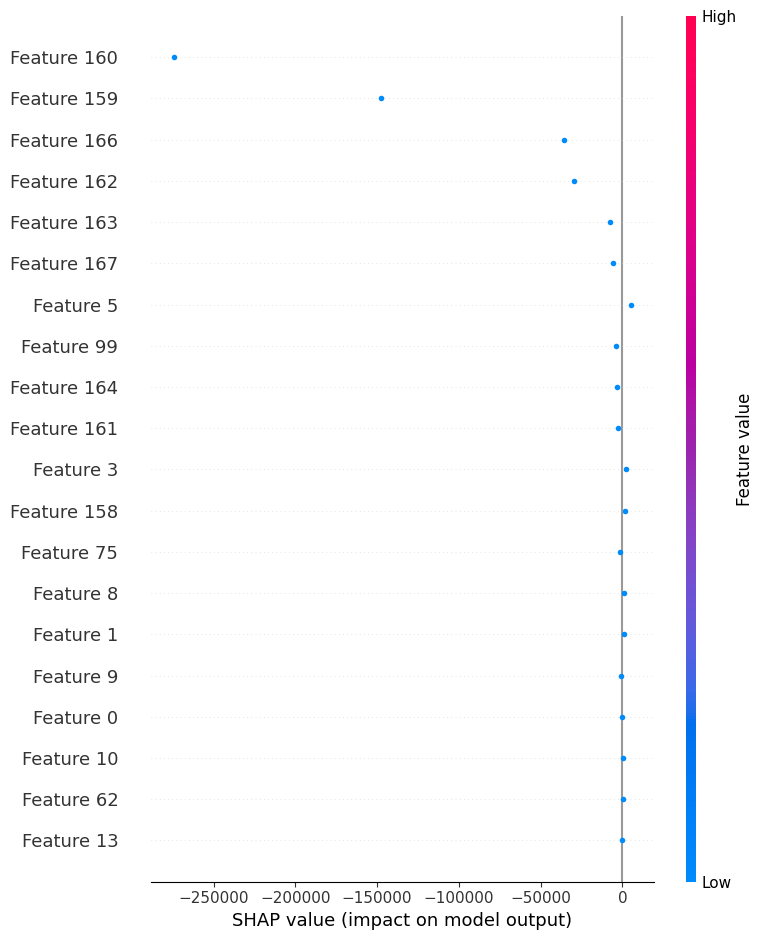

In [41]:

# model = regressorRFR  

# Initialize explainer with the training data
explainer = shap.Explainer(regressorRFR)

# Calculate SHAP values for a single prediction
shap_values = explainer.shap_values(test_input_final)

# Plot summary plot or force plot
shap.summary_plot(shap_values, test_input_final)


In [48]:
import shap
from lime import lime_tabular

# Assuming you have already loaded your models and data

# SHAP Explanation
explainer_shap = shap.Explainer(regressorRFR, X_train_final)
shap_values = explainer_shap.shap_values(test_input_final)

# Use shap.summary_plot with feature names
shap.summary_plot(shap_values, test_input_final, feature_names=['max power', 'max torque', 'fuel tank capacity', 'top speed', 'kerb weight', 'overall height', 'overall length', 'overall width', 'wheelbase'] + ohe2.get_feature_names_out(['brand','name', 'front brake type']))

# LIME Explanation
explainer_lime = lime_tabular.LimeTabularExplainer(X_train_final, feature_names=['max power', 'max torque', 'fuel tank capacity', 'top speed', 'kerb weight', 'overall height', 'overall length', 'overall width', 'wheelbase'] + ohe2.get_feature_names_out(['brand','name', 'front brake type']))

# Explain a specific instance with LIME
lime_explanation = explainer_lime.explain_instance(test_input_final[0], regressorRFR.predict, num_features=10)

# Show the LIME explanation
lime_explanation.show_in_notebook(show_table=True)

ValueError: operands could not be broadcast together with shapes (9,) (159,) 